# Work group 7

## 1. CAUSAL FOREST

This workgroup replicates the results obtaines by Athey and Wager (2019) about The National Study of Learning Mindsets, a randomized study focused on evaluating the impact of instilling students with a growth mindset over academic achievement.

The included variables are:

$S3$: Student's self-reported expectations for success in the future, a proxy for prior achievement, measured prior to random assignment

$C1$: Categorical variable for student race/ethnicity

$C2$: Categorical variable for student identified gender

$C3$: Categorical variable for student first-generation status, i.e. first in family to go to college

$XC$: School-level categorical variable for urbanicity of the school, i.e. rural, suburban,etc.

$X1$: School-level mean of students' xed mindsets, reported prior to random assignment

$X2$: School achievement level, as measured by test scores and college preparation for the previous 4 cohorts of students

$X3$: School racial/ethnic minority composition, i.e., percentage of student body that is Black, Latino, or Native American

$X4$: School poverty concentration, i.e., percentage of students who are from families whose incomes fall below the federal poverty line

$X5$: School size, i.e., total number of students in all four grade levels in the school

$Y$: Post-treatment outcome, a continuous measure of achievement

$W$: Treatment, i.e., receipt of the intervention

Being $Y$ and $W$ the main variables of interest.

In [1]:
install.packages("Hmisc")
install.packages('grf')



  There is a binary version available but the source version is later:
      binary source needs_compilation
Hmisc  4.5-0  4.6-0              TRUE



installing the source package 'Hmisc'





  There is a binary version available but the source version is later:
    binary source needs_compilation
grf  1.2.0  2.0.2              TRUE



installing the source package 'grf'




In [2]:
set.seed(1)

rm(list = ls())

library(grf)
if(packageVersion("grf") < '0.10.2') {
  warning("This script requires grf 0.10.2 or higher")
}
library(sandwich)
library(lmtest)
library(Hmisc)
library(ggplot2)

Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Loading required package: lattice

Warning message:
"package 'lattice' was built under R version 3.6.3"
Loading required package: survival

Warning message:
"package 'survival' was built under R version 3.6.3"
Loading required package: Formula

Warning message:
"package 'Formula' was built under R version 3.6.3"
Loading required package: ggplot2


Attaching package: 'Hmisc'


The following objects are masked from 'package:base':

    format.pval, units




In [37]:
data.all = read.csv("synthetic_data.csv")
data.all$schoolid = factor(data.all$schoolid)

DF = data.all[,-1]
school.id = as.numeric(data.all$schoolid)

school.mat = model.matrix(~ schoolid + 0, data = data.all)
school.size = colSums(school.mat)

In [38]:
# It appears that school ID does not affect pscore. So ignore it
# in modeling, and just treat it as source of per-cluster error.
w.lm = glm(Z ~ ., data = data.all[,-3], family = binomial)
summary(w.lm)


Call:
glm(formula = Z ~ ., family = binomial, data = data.all[, -3])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.2079  -0.9088  -0.8297   1.4176   1.9556  

Coefficients: (6 not defined because of singularities)
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.9524636  0.2845173  -3.348 0.000815 ***
schoolid2    0.0697302  0.2766287   0.252 0.800986    
schoolid3    0.0382080  0.2911323   0.131 0.895586    
schoolid4    0.1761334  0.2784711   0.633 0.527059    
schoolid5   -0.0033389  0.2950180  -0.011 0.990970    
schoolid6    0.0583548  0.3067481   0.190 0.849124    
schoolid7   -0.1313759  0.3188190  -0.412 0.680288    
schoolid8    0.1233661  0.3023736   0.408 0.683279    
schoolid9   -0.1955428  0.3073344  -0.636 0.524611    
schoolid10  -0.1892794  0.2968750  -0.638 0.523752    
schoolid11  -0.2224060  0.5461005  -0.407 0.683816    
schoolid12  -0.3312420  0.5414374  -0.612 0.540682    
schoolid13  -0.0408540  0.3989507  -0.102 0.9

In [39]:
W = DF$Z
Y = DF$Y
X.raw = DF[,-(1:2)]

C1.exp = model.matrix(~ factor(X.raw$C1) + 0)
XC.exp = model.matrix(~ factor(X.raw$XC) + 0)

X = cbind(X.raw[,-which(names(X.raw) %in% c("C1", "XC"))], C1.exp, XC.exp)

### 1. BUILT TREE

In [40]:
# Grow a forest. Add extra trees for the causal forest.
#

Y.forest = regression_forest(X, Y, clusters = school.id, equalize.cluster.weights = TRUE)
Y.hat = predict(Y.forest)$predictions
W.forest = regression_forest(X, W, clusters = school.id, equalize.cluster.weights = TRUE)
W.hat = predict(W.forest)$predictions

cf.raw = causal_forest(X, Y, W,
                       Y.hat = Y.hat, W.hat = W.hat,
                       clusters = school.id,
                       equalize.cluster.weights = TRUE)
varimp = variable_importance(cf.raw)
selected.idx = which(varimp > mean(varimp))

cf = causal_forest(X[,selected.idx], Y, W,
                   Y.hat = Y.hat, W.hat = W.hat,
                   clusters = school.id,
                   equalize.cluster.weights = TRUE,
                   tune.parameters = "all")
tau.hat = predict(cf)$predictions

### 2. Average Treatment Effect (ATE)

The ATE is defined as:

$$
\tau = E[Y_i (1) - Y_i(0)]
$$

In [41]:

ATE = average_treatment_effect(cf)
paste("95% CI for the ATE:", round(ATE[1], 3),
      "+/-", round(qnorm(0.975) * ATE[2], 3))

[1] "95% CI for the ATE: 0.247 +/- 0.039"

Here we can see that the ATE is $0.247$ with a confidence interval of $+/- 0.039$ which means the study has a positive effect in instilling students with a growth mindset.

### 3. Run best linear predictor analysis
As explained by the authors, the best linear predictor indicates whether or not treatment heterogeneity estimates are well-calibrated. Since the estimator is close to $1$ and significant, we can assume the causal forest was successful in finding heterogeneity.

In [42]:
# Run best linear predictor analysis
test_calibration(cf)

# Compare regions with high and low estimated CATEs
high_effect = tau.hat > median(tau.hat)
ate.high = average_treatment_effect(cf, subset = high_effect)
ate.low = average_treatment_effect(cf, subset = !high_effect)
paste("95% CI for difference in ATE:",
      round(ate.high[1] - ate.low[1], 3), "+/-",
      round(qnorm(0.975) * sqrt(ate.high[2]^2 + ate.low[2]^2), 3))




Best linear fit using forest predictions (on held-out data)
as well as the mean forest prediction as regressors, along
with one-sided heteroskedasticity-robust (HC3) SEs:

                               Estimate Std. Error t value Pr(>t)    
mean.forest.prediction          1.00401    0.08309 12.0834 <2e-16 ***
differential.forest.prediction  0.34871    0.60622  0.5752 0.2826    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


[1] "95% CI for difference in ATE: 0.045 +/- 0.075"

In [43]:
# formal test for X1 and X2

dr.score = tau.hat + W / cf$W.hat *
  (Y - cf$Y.hat - (1 - cf$W.hat) * tau.hat) -
  (1 - W) / (1 - cf$W.hat) * (Y - cf$Y.hat + cf$W.hat * tau.hat)
school.score = t(school.mat) %*% dr.score / school.size

school.X1 = t(school.mat) %*% X$X1 / school.size
high.X1 = school.X1 > median(school.X1)
t.test(school.score[high.X1], school.score[!high.X1])

school.X2 = (t(school.mat) %*% X$X2) / school.size
high.X2 = school.X2 > median(school.X2)
t.test(school.score[high.X2], school.score[!high.X2])

school.X2.levels = cut(school.X2,
  breaks = c(-Inf, quantile(school.X2, c(1/3, 2/3)), Inf))
summary(aov(school.score ~ school.X2.levels))


	Welch Two Sample t-test

data:  school.score[high.X1] and school.score[!high.X1]
t = -3.008, df = 72.14, p-value = 0.003619
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.19083219 -0.03871302
sample estimates:
mean of x mean of y 
0.1895662 0.3043388 



	Welch Two Sample t-test

data:  school.score[high.X2] and school.score[!high.X2]
t = 1.0594, df = 72.091, p-value = 0.293
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -0.03747253  0.12247204
sample estimates:
mean of x mean of y 
0.2682024 0.2257027 


                 Df Sum Sq Mean Sq F value Pr(>F)
school.X2.levels  2 0.0863 0.04313   1.424  0.247
Residuals        73 2.2110 0.03029               


	One Sample t-test

data:  school.score.XS3.high - school.score.XS3.low
t = 2.1917, df = 75, p-value = 0.0315
alternative hypothesis: true mean is not equal to 0
95 percent confidence interval:
 0.007566835 0.158589267
sample estimates:
 mean of x 
0.08307805 


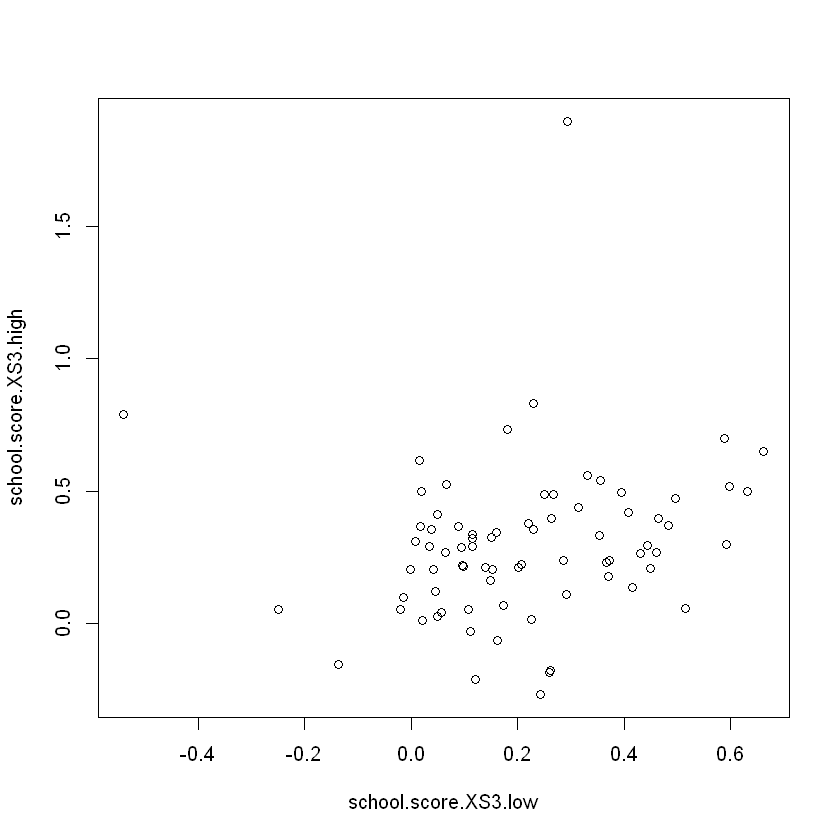

In [44]:
# formal test for S3
school.score.XS3.high = t(school.mat) %*% (dr.score * (X$S3 >= 6)) /
  t(school.mat) %*% (X$S3 >= 6)
school.score.XS3.low = t(school.mat) %*% (dr.score * (X$S3 < 6)) /
  t(school.mat) %*% (X$S3 < 6)

plot(school.score.XS3.low, school.score.XS3.high)
t.test(school.score.XS3.high - school.score.XS3.low)

### 4. School-wise heterogeneity

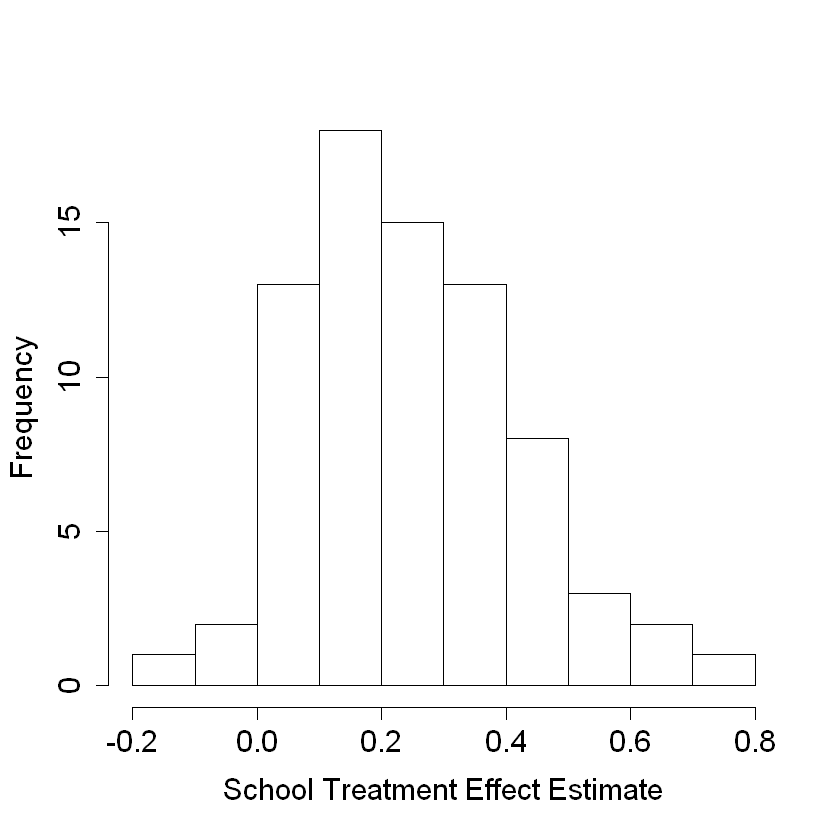

In [45]:
# Look at school-wise heterogeneity
#pdf("school_hist.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
hist(school.score, xlab = "School Treatment Effect Estimate", main = "")
#dev.off()

In [46]:
# Re-check ATE... sanity check only
ate.hat = mean(school.score)
se.hat = sqrt(var(school.score) / length(school.score - 1))
print(paste(round(ate.hat, 3), "+/-", round(1.96 * se.hat, 3)))

[1] "0.247 +/- 0.039"


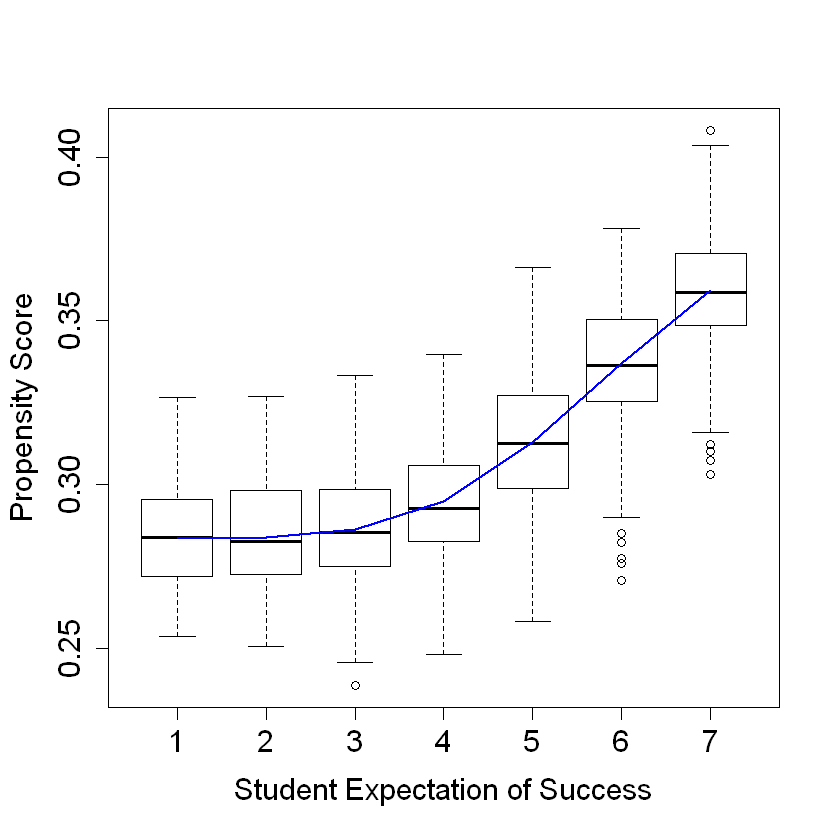

In [47]:
# Look at variation in propensity scores

DF = X
DF$W.hat = cf$W.hat

#pdf("pscore.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
boxplot(W.hat ~ S3, data = DF, ylab = "Propensity Score", xlab = "Student Expectation of Success")
lines(smooth.spline(X$S3, cf$W.hat), lwd = 2, col = 4)
#dev.off()


We see that students with a higher expectation of success are more likely to receive treatment.

### 5. Analysis ignoring clusters
When ignoring clusters, the ATE is slightly bigger at $0.252$, with a smaller confidence interval (roughly half of the previous CI) of $+/- 0.022$.

[1] "95% CI for the ATE: 0.252 +/- 0.022"


Best linear fit using forest predictions (on held-out data)
as well as the mean forest prediction as regressors, along
with one-sided heteroskedasticity-robust (HC3) SEs:

                               Estimate Std. Error t value    Pr(>t)    
mean.forest.prediction         1.008914   0.045079 22.3811 < 2.2e-16 ***
differential.forest.prediction 0.518728   0.122947  4.2191 1.237e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


[1] 1
[1] 2
[1] 3
[1] 4
[1] 5



Best linear fit using forest predictions (on held-out data)
as well as the mean forest prediction as regressors, along
with one-sided heteroskedasticity-robust (HC3) SEs:

                               Estimate Std. Error t value Pr(>t)    
mean.forest.prediction         0.985974   0.065001 15.1685 <2e-16 ***
differential.forest.prediction 0.180932   0.178758  1.0122 0.1557    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


[1] 4.355145e-05 9.168641e-04

                     Df Sum Sq Mean Sq F value   Pr(>F)    
factor(school.id)    75    201   2.681   1.986 9.36e-07 ***
Residuals         10315  13920   1.349                     
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

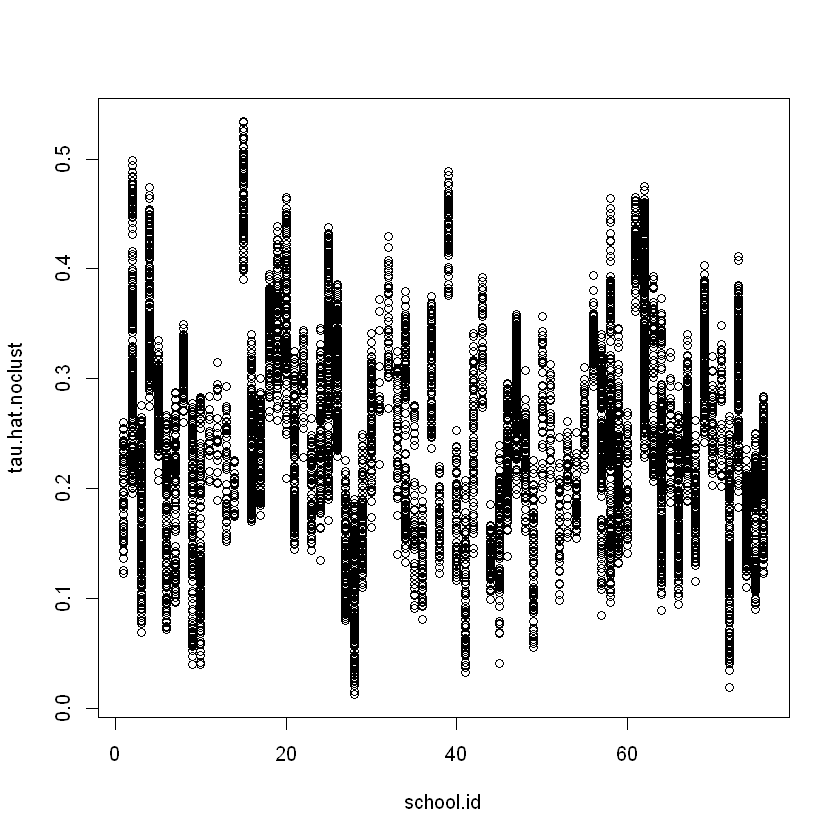

In [48]:


cf.noclust = causal_forest(X[,selected.idx], Y, W,
                           Y.hat = Y.hat, W.hat = W.hat,
                           tune.parameters = "all")

ATE.noclust = average_treatment_effect(cf.noclust)
paste("95% CI for the ATE:", round(ATE.noclust[1], 3),
      "+/-", round(qnorm(0.975) * ATE.noclust[2], 3))

test_calibration(cf.noclust)

tau.hat.noclust = predict(cf.noclust)$predict
plot(school.id, tau.hat.noclust)

nfold = 5
school.levels = unique(school.id)
cluster.folds = sample.int(nfold, length(school.levels), replace = TRUE)

tau.hat.crossfold = rep(NA, length(Y))
for (foldid in 1:nfold) {
  print(foldid)
  infold = school.id %in% school.levels[cluster.folds == foldid]
  cf.fold = causal_forest(X[!infold, selected.idx], Y[!infold], W[!infold],
                          Y.hat = Y.hat[!infold], W.hat = W.hat[!infold],
                          tune.parameters = "all")
  pred.fold = predict(cf.fold, X[infold, selected.idx])$predictions
  tau.hat.crossfold[infold] = pred.fold
}

cf.noclust.cpy = cf.noclust
cf.noclust.cpy$predictions = tau.hat.crossfold
cf.noclust.cpy$clusters = school.id
test_calibration(cf.noclust.cpy)

Rloss = mean(((Y - Y.hat) - tau.hat * (W - W.hat))^2)
Rloss.noclust = mean(((Y - Y.hat) - tau.hat.noclust * (W - W.hat))^2)
Rloss.crossfold = mean(((Y - Y.hat) - tau.hat.crossfold * (W - W.hat))^2)

c(Rloss.noclust - Rloss, Rloss.crossfold - Rloss)

summary(aov(dr.score ~ factor(school.id)))


### 6. Analysis without fitting propensity score
We notice that training a causal forest without accounting for propensity score does not significantly change the ATE (from $0.257$ to %0.254$), even though we saw a significant relationship between a higher expectation of success and the likeliness of receiving treatment. The authors note that this may be because of the presence of more relevant confounders in the estimation

[1] "95% CI for the ATE: 0.254 +/- 0.039"

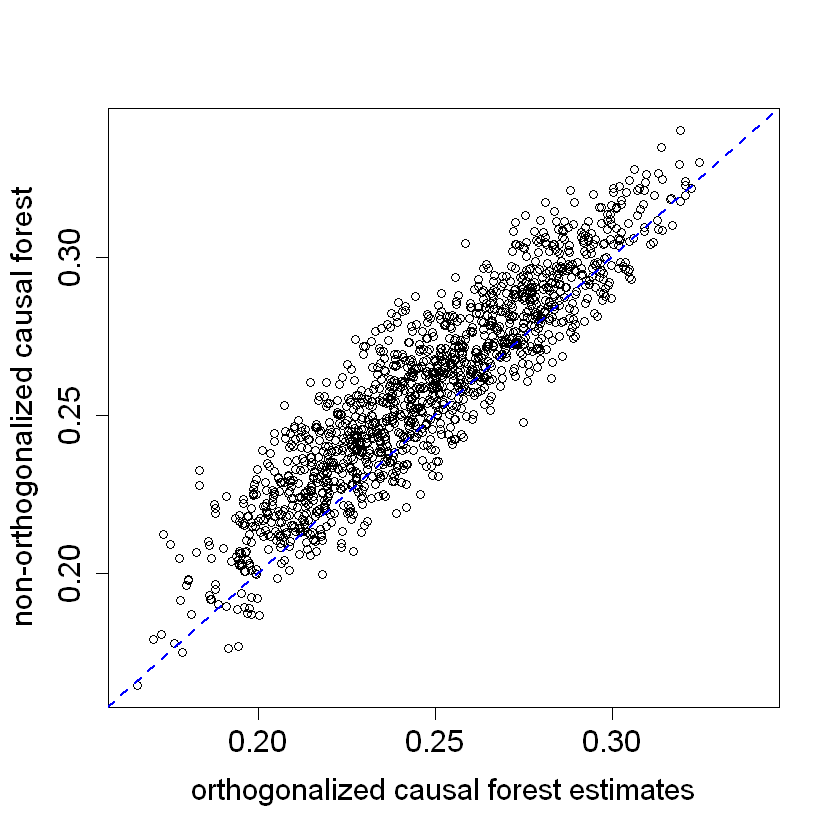

In [49]:

cf.noprop = causal_forest(X[,selected.idx], Y, W,
                          Y.hat = Y.hat, W.hat = mean(W),
                          tune.parameters = "all",
                          equalize.cluster.weights = TRUE,
                          clusters = school.id)
tau.hat.noprop = predict(cf.noprop)$predictions

ATE.noprop = average_treatment_effect(cf.noprop)
paste("95% CI for the ATE:", round(ATE.noprop[1], 3),
      "+/-", round(qnorm(0.975) * ATE.noprop[2], 3))

#pdf("tauhat_noprop.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
plot(tau.hat, tau.hat.noprop,
     xlim = range(tau.hat, tau.hat.noprop),
     ylim = range(tau.hat, tau.hat.noprop),
     xlab = "orthogonalized causal forest estimates",
     ylab = "non-orthogonalized causal forest")
abline(0, 1, lwd = 2, lty = 2, col = 4)
par = pardef
#dev.off()

In [50]:
# Train forest on school-wise DR scores
school.X = (t(school.mat) %*% as.matrix(X[,c(4:8, 25:28)])) / school.size
school.X = data.frame(school.X)
colnames(school.X) = c("X1", "X2", "X3", "X4", "X5",
                    "XC.1", "XC.2", "XC.3", "XC.4")

dr.score = tau.hat + W / cf$W.hat * (Y - cf$Y.hat - (1 - cf$W.hat) * tau.hat) -
  (1 - W) / (1 - cf$W.hat) * (Y - cf$Y.hat + cf$W.hat * tau.hat)
school.score = t(school.mat) %*% dr.score / school.size

school.forest = regression_forest(school.X, school.score)
school.pred = predict(school.forest)$predictions
test_calibration(school.forest)
# Alternative OLS analysis
school.DF = data.frame(school.X, school.score=school.score)
coeftest(lm(school.score ~ ., data = school.DF), vcov = vcovHC)


Best linear fit using forest predictions (on held-out data)
as well as the mean forest prediction as regressors, along
with one-sided heteroskedasticity-robust (HC3) SEs:

                               Estimate Std. Error t value Pr(>t)    
mean.forest.prediction         1.001053   0.082461 12.1397 <2e-16 ***
differential.forest.prediction 0.611246   0.680871  0.8977 0.1861    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



t test of coefficients:

               Estimate  Std. Error t value Pr(>|t|)   
(Intercept)  0.23952296  0.07580088  3.1599 0.002382 **
X1          -0.04855529  0.02918943 -1.6635 0.100963   
X2           0.01534597  0.03369033  0.4555 0.650244   
X3           0.00991045  0.02636194  0.3759 0.708169   
X4           0.02397930  0.02555046  0.9385 0.351406   
X5          -0.03546880  0.02636144 -1.3455 0.183075   
XC.1        -0.00078854  0.09142689 -0.0086 0.993145   
XC.2         0.08676230  0.10408907  0.8335 0.407547   
XC.3        -0.13202118  0.08592408 -1.5365 0.129200   
XC.4         0.04528332  0.08114261  0.5581 0.578684   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


### 7. SOME PLOTS

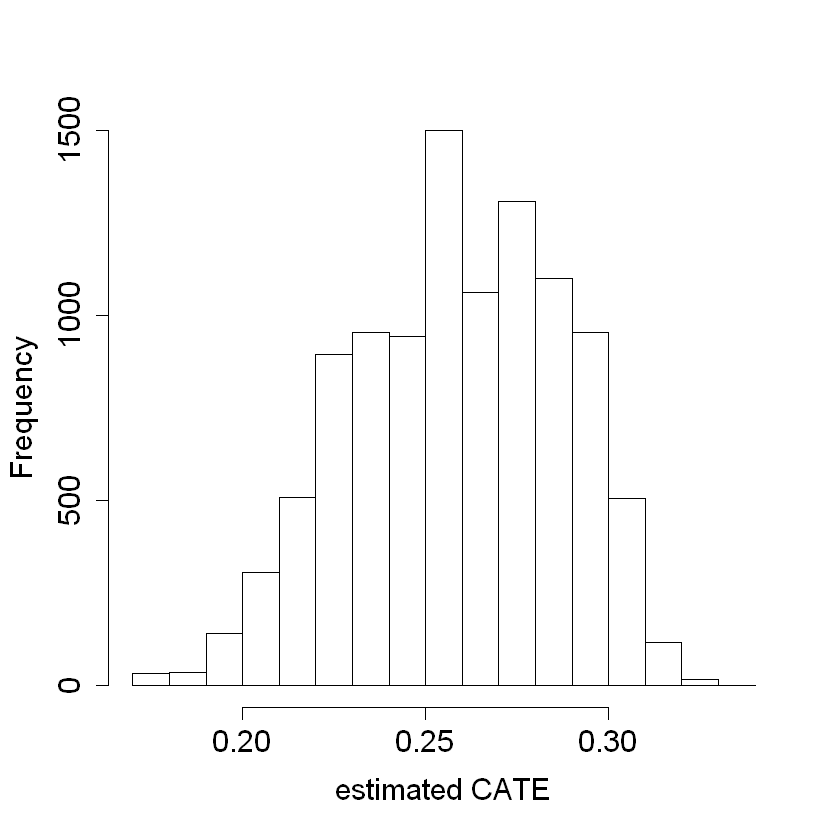

In [17]:

#pdf("tauhat_hist.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
hist(tau.hat, xlab = "estimated CATE", main = "")
#dev.off()

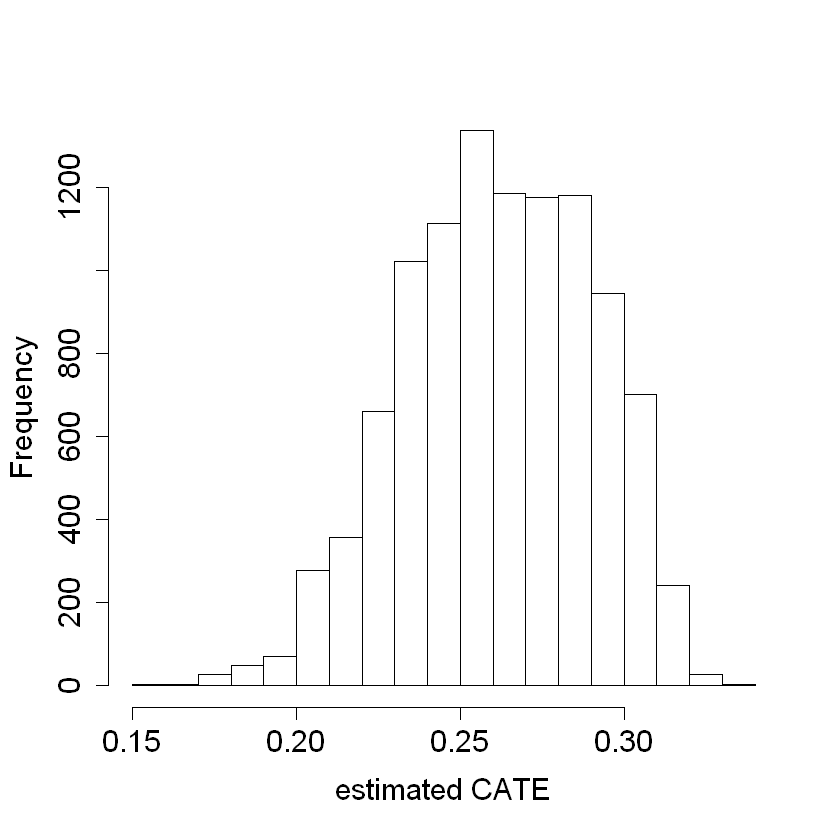

In [18]:
#pdf("tauhat_hist_noprop.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
hist(tau.hat.noprop, xlab = "estimated CATE", main = "")
#dev.off()

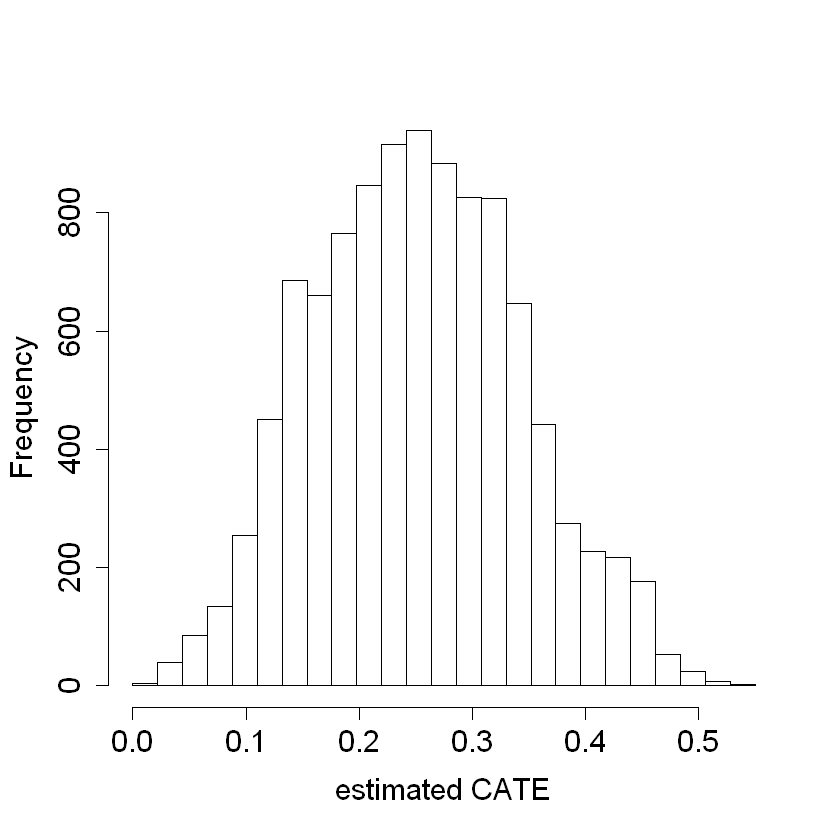

In [51]:

#pdf(\"tauhat_hist_noclust.pdf\")\n",
    pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
    hist(tau.hat.noclust, xlab = "estimated CATE", main = "",
         breaks = seq(-0.0, 0.55, by = 0.55 /25 ))
#dev.off()


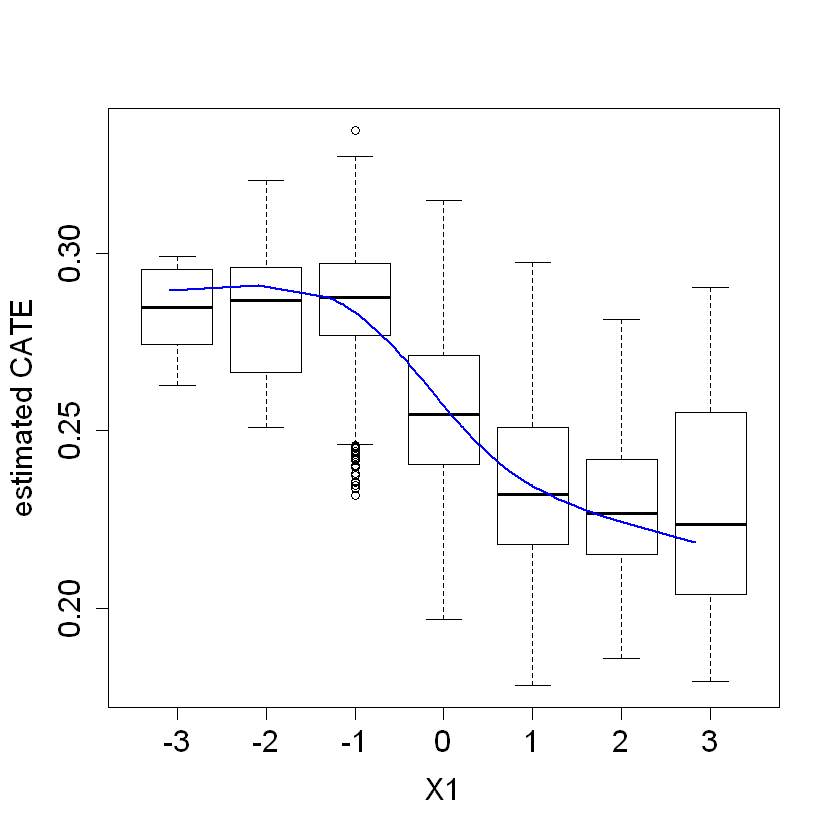

In [20]:
#pdf("tauhat_vs_X1.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
boxplot(tau.hat ~ round(X$X1), xlab = "X1", ylab = "estimated CATE")
lines(smooth.spline(4 + X[,"X1"], tau.hat, df = 4), lwd = 2, col = 4)
#dev.off()

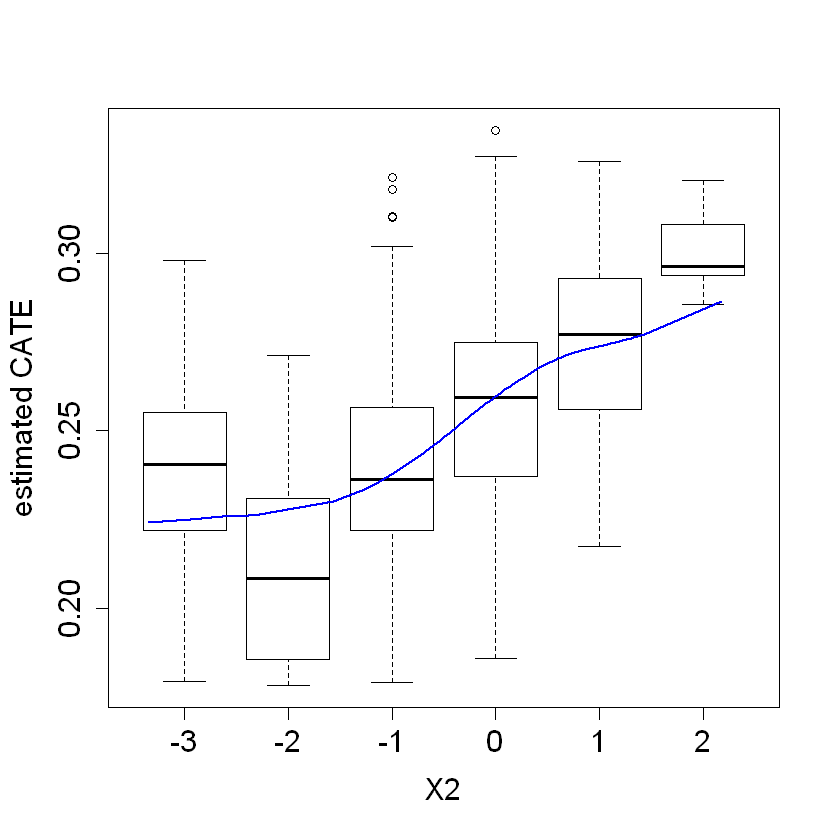

In [21]:
#pdf("tauhat_vs_X2.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
boxplot(tau.hat ~ round(X$X2), xlab = "X2", ylab = "estimated CATE")
lines(smooth.spline(4 + X[,"X2"], tau.hat, df = 4), lwd = 2, col = 4)
#dev.off()

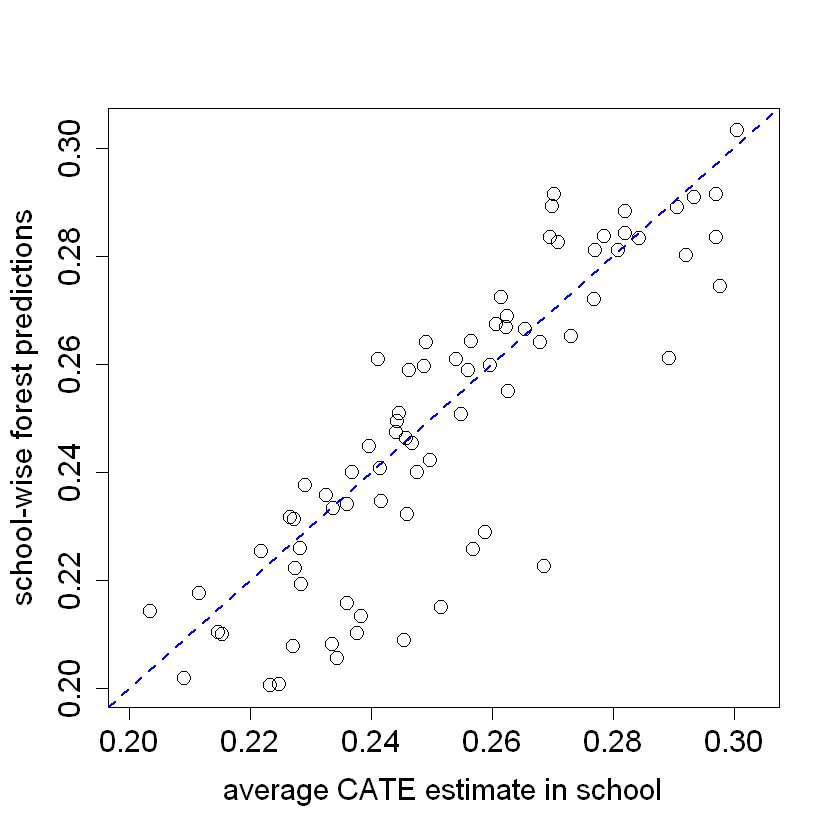

In [22]:
school.avg.tauhat = t(school.mat) %*% tau.hat / school.size
#pdf("school_avg.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
plot(school.avg.tauhat, school.pred, cex = 1.5,
     xlim = range(school.avg.tauhat, school.pred),
     ylim = range(school.avg.tauhat, school.pred),
     xlab = "average CATE estimate in school",
     ylab = "school-wise forest predictions")
abline(0, 1, lwd = 2, lty = 2, col = 4)
par = pardef
#dev.off()

The first plot shows us the histogram of the estimated parameters of the CATE with clustered data and with proportionalized samples with propensity scores. This is the 'benchmark model' we are testing.

Here the causal forest is trained using a trivial propensity (every observation has the same 'weight'). As a consequence we can observe that the histogram is more disperse ç. This suggest that there are prescence of some counfounders (variables that are important to predict W but Y as well).

The third histogram shows the case when the causal fores is trained ignoring clustering. We can observe that the disperssion of the histogram is way much greater that in the previous cases. This could be related to the fact that there might be some school-specific effects that are being ignored when not considering clustering at school level.

The first box-plot show the relation between the CATE and $X1$ which is the pre-existing mindset at school level. This highlights the fact that there might exist treatment heterogenity. It's important to remind that this is not a student-specific feature but a school-specific feature which is more interesting when considering clustering.

The second boxplot show the how CATE vary e by school achievement level. The plot suggest that greater school achievement level lead to bigger CATEs. This also highlights the possibility of clustering.

The final plot is a scatter plot that comapres the average CATE of each school vs the predictions made with the regression forest for each school. This is a final visual reminder of how important school-specific characteristic might be

In [23]:
# Experiment with no orthogonalization
n.synth = 1000
p.synth = 10
X.synth = matrix(rnorm(n.synth * p.synth), n.synth, p.synth)
W.synth = rbinom(n.synth, 1, 1 / (1 + exp(-X.synth[,1])))
Y.synth = 2 * rowMeans(X.synth[,1:6]) + rnorm(n.synth)

Y.forest.synth = regression_forest(X.synth, Y.synth)
Y.hat.synth = predict(Y.forest.synth)$predictions
W.forest.synth = regression_forest(X.synth, W.synth)
W.hat.synth = predict(W.forest.synth)$predictions

cf.synth = causal_forest(X.synth, Y.synth, W.synth,
                         Y.hat = Y.hat.synth, W.hat = W.hat.synth)
ATE.synth = average_treatment_effect(cf.synth)
paste("95% CI for the ATE:", round(ATE.synth[1], 3),
      "+/-", round(qnorm(0.975) * ATE.synth[2], 3))

cf.synth.noprop = causal_forest(X.synth, Y.synth, W.synth,
                                Y.hat = Y.hat.synth, W.hat = mean(W.synth))
ATE.synth.noprop = average_treatment_effect(cf.synth.noprop)
paste("95% CI for the ATE:", round(ATE.synth.noprop[1], 3),
      "+/-", round(qnorm(0.975) * ATE.synth.noprop[2], 3))

[1] "95% CI for the ATE: -0.055 +/- 0.144"

[1] "95% CI for the ATE: 0.055 +/- 0.143"

### 8. Visualize school-level covariates by treatment heterogeneity

[1] 0.2105263

[1] 0.5384615

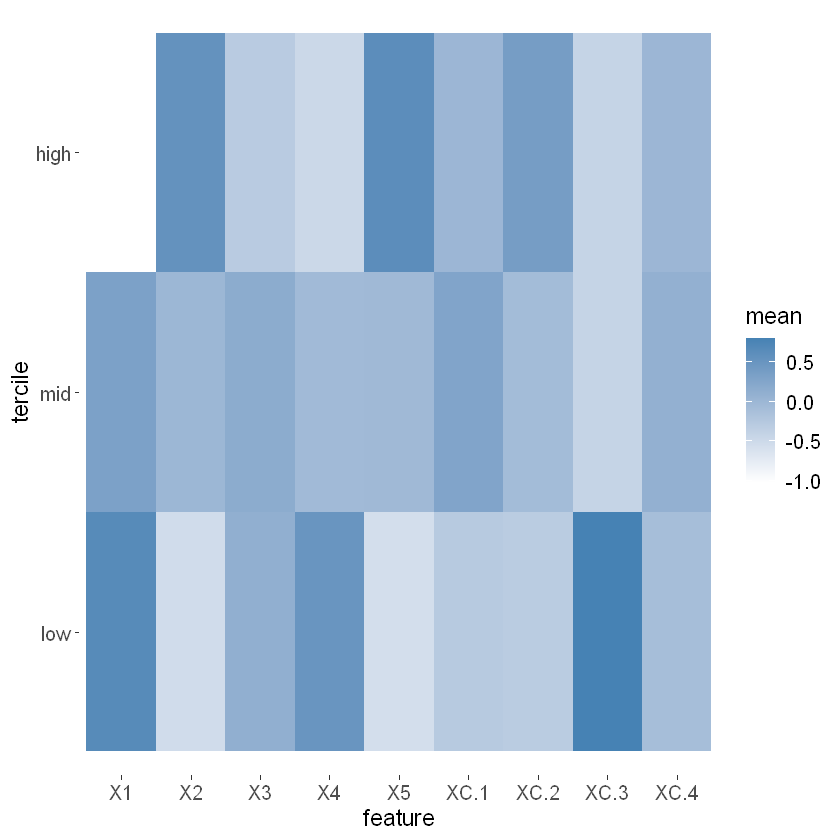

In [24]:

school.X.std = scale(school.X)
school.tercile = cut(school.pred,
                     breaks = c(-Inf, quantile(school.pred, c(1/3, 2/3)), Inf))
school.tercile.mat = model.matrix(~ school.tercile + 0)
school.means = diag(1 / colSums(school.tercile.mat)) %*% t(school.tercile.mat) %*% as.matrix(school.X.std)

MM = max(abs(school.means))
HC = heat.colors(21)
school.col = apply(school.means, 1:2, function(aa) HC[1 + round(20 * (0.5 + aa))])

DF.plot = data.frame(tercile=rep(factor(1:3, labels=c("low", "mid", "high")), 9), mean=as.numeric(school.means),
                     feature = factor(rbind(colnames(school.X), colnames(school.X), colnames(school.X))))

ggplot(data = DF.plot, aes(x = feature, y = tercile, fill = mean)) +
    geom_tile() + scale_fill_gradient(low = "white", high = "steelblue") +
    theme(axis.text = element_text(size=12), axis.title = element_text(size=14),
          legend.title = element_text(size=14), legend.text = element_text(size=12)) +
    theme(panel.background = element_blank())
ggsave("tercile_plot.pdf", width = 8, height = 4.5, dpi = 120)

mean(school.X$XC.3)
mean(school.X$XC.3[as.numeric(school.tercile) == 1])

The matrix that appears confirm us that some school-specific features might characterize greater or smaller effects. There are some features that characterize more heterogenity ($X1$ , $X2$, $X4$ = Poverty concentration and $X5$ = school size). However, there are also some school characteristichs that show no major treatment heterogenity (such as the school minority composition).

### 9. CATE by school

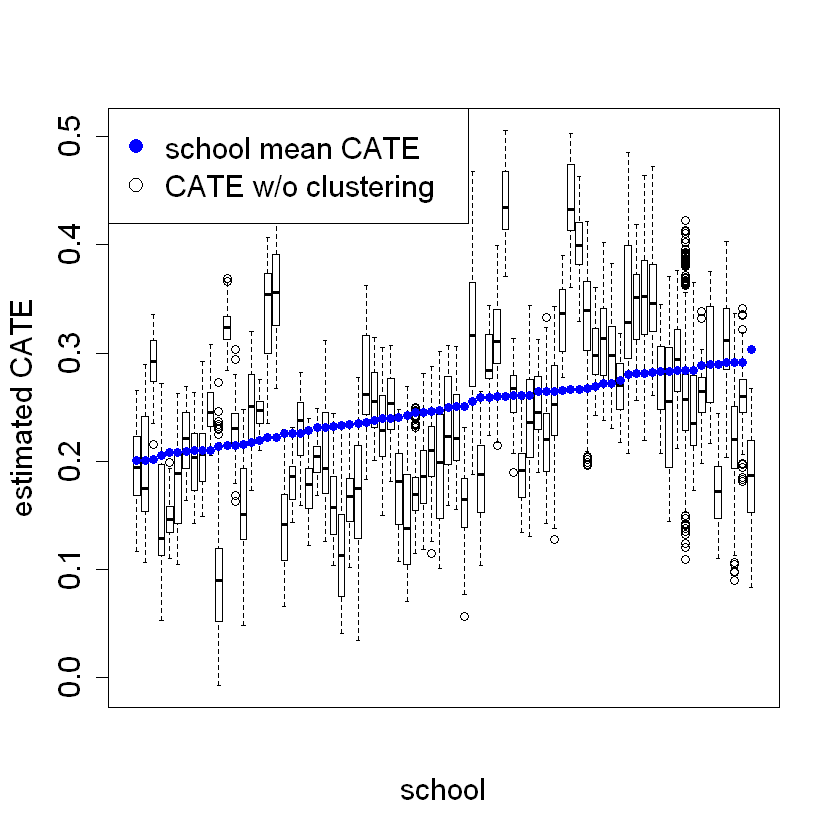

In [25]:

ord = order(order(school.pred))
school.sort = ord[school.id]

#pdf("school_boxplot.pdf")
pardef = par(mar = c(5, 4, 4, 2) + 0.5, cex.lab=1.5, cex.axis=1.5, cex.main=1.5, cex.sub=1.5)
boxplot(tau.hat.noclust ~ school.sort, xaxt = "n",
        xlab = "school", ylab = "estimated CATE")
points(1:76, sort(school.pred), col = 4, pch = 16)
legend("topleft", c("school mean CATE", "CATE w/o clustering"), pch = c(16, 1), col = c(4, 1), cex = 1.5)
par = pardef
#dev.off()

The matrix that appears confirm us that some school-specific features might characterize greater or smaller effects. There are some features that characterize more heterogenity ($X1$ , $X2$, $X4$ = Poverty concentration and $X5$ = school size). However, there are also some school characteristichs that show no major treatment heterogenity (such as the school minority composition).

# PART 2

## 2. Debiased Machine Learning

In [3]:
library(dplyr)
library(ggplot2)
library(caTools)
library(hdm)
library(glmnet)
library(sandwich)
library(randomForest)

GrowthData <- GrowthData
save(GrowthData, file = "C:/Users/Gonzalo/Documents/GitHub/grf/GrowthData.RData")
attach(GrowthData)
names(GrowthData)
dim(GrowthData)
GrowthData

Warning message:
"package 'dplyr' was built under R version 3.6.3"

Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Warning message:
"package 'caTools' was built under R version 3.6.3"
Warning message:
"package 'hdm' was built under R version 3.6.3"
Warning message:
"package 'glmnet' was built under R version 3.6.3"
Loading required package: Matrix

Warning message:
"package 'Matrix' was built under R version 3.6.3"
Loaded glmnet 4.1-1

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: 'randomForest'


The following object is masked from 'package:ggplot2':

    margin


The following object is masked from 'package:dplyr':

    combine




[1] "Outcome"   "intercept" "gdpsh465"  "bmp1l"     "freeop"    "freetar"  
 [7] "h65"       "hm65"      "hf65"      "p65"       "pm65"      "pf65"     
[13] "s65"       "sm65"      "sf65"      "fert65"    "mort65"    "lifee065" 
[19] "gpop1"     "fert1"     "mort1"     "invsh41"   "geetot1"   "geerec1"  
[25] "gde1"      "govwb1"    "govsh41"   "gvxdxe41"  "high65"    "highm65"  
[31] "highf65"   "highc65"   "highcm65"  "highcf65"  "human65"   "humanm65" 
[37] "humanf65"  "hyr65"     "hyrm65"    "hyrf65"    "no65"      "nom65"    
[43] "nof65"     "pinstab1"  "pop65"     "worker65"  "pop1565"   "pop6565"  
[49] "sec65"     "secm65"    "secf65"    "secc65"    "seccm65"   "seccf65"  
[55] "syr65"     "syrm65"    "syrf65"    "teapri65"  "teasec65"  "ex1"      
[61] "im1"       "xr65"      "tot1"

[1] 90 63

Outcome,intercept,gdpsh465,bmp1l,freeop,freetar,h65,hm65,hf65,p65,...,seccf65,syr65,syrm65,syrf65,teapri65,teasec65,ex1,im1,xr65,tot1
<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-0.02433575,1,6.591674,0.2837,0.153491,0.043888,0.007,0.013,0.001,0.29,...,0.04,0.033,0.057,0.010,47.6,17.3,0.0729,0.0667,0.348,-0.014727
0.10047257,1,6.829794,0.6141,0.313509,0.061827,0.019,0.032,0.007,0.91,...,0.64,0.173,0.274,0.067,57.1,18.0,0.0940,0.1438,0.525,0.005750
0.06705148,1,8.895082,0.0000,0.204244,0.009186,0.260,0.325,0.201,1.00,...,18.14,2.573,2.478,2.667,26.5,20.7,0.1741,0.1750,1.082,-0.010040
0.06408917,1,7.565275,0.1997,0.248714,0.036270,0.061,0.070,0.051,1.00,...,2.63,0.438,0.453,0.424,27.8,22.7,0.1265,0.1496,6.625,-0.002195
0.02792955,1,7.162397,0.1740,0.299252,0.037367,0.017,0.027,0.007,0.82,...,2.11,0.257,0.287,0.229,34.5,17.6,0.1211,0.1308,2.500,0.003283
0.04640744,1,7.218910,0.0000,0.258865,0.020880,0.023,0.038,0.006,0.50,...,1.46,0.160,0.174,0.146,34.3,8.1,0.0634,0.0762,1.000,-0.001747
0.06733234,1,7.853605,0.0000,0.182525,0.014385,0.039,0.063,0.014,0.92,...,1.59,0.342,0.484,0.207,46.6,14.7,0.0342,0.0428,12.499,0.009092
0.02097768,1,7.703910,0.2776,0.215275,0.029713,0.024,0.035,0.013,0.69,...,1.63,0.184,0.219,0.152,34.0,16.1,0.0864,0.0931,7.000,0.011630
0.03355124,1,9.063463,0.0000,0.109614,0.002171,0.402,0.488,0.314,1.00,...,24.72,3.206,3.154,3.253,28.2,20.6,0.0594,0.0460,1.000,0.008169


In [4]:
y <- c("Outcome")
d <- c("gdpsh465")
z1 <- c("govsh41", "govwb1", "gpop1", "gvxdxe41", "h65", "high65" , "hm65", "human65")
z2 <- c("p65", "pf65", "pinstab1", "pm65", "pop1565", "pop65", "s65", "sec65", "secc65")
z3 <- c("seccf65", "seccm65", "secf65", "secm65", "sf65", "sm65", "syr65", "syrf65")        
z4 <- c("syrm65", "teapri65", "teasec65", "tot1", "worker65", "xr65")        
        
# Treatment Variable
d <- GrowthData[which(colnames(GrowthData) == d)]
# Outcome Variable
y  <- GrowthData[which(colnames(GrowthData) == y)]
# Construct matrix Z
z <- GrowthData[which(colnames(GrowthData) %in% c(z1,z2,z3,z4))]

### 1. OLS without including the country characteristics.
***
We estimate a model of the outcome variable just on the treatment variable (initial wealth). That is:

 $$
  Y = \beta_1 D  + \epsilon.
  $$

In [5]:

baseline_formula <- as.formula(paste(y, "~", d ))
baseline.ols <- lm(baseline_formula,data=GrowthData)
est_baseline <- summary(baseline.ols)$coef[2,]
confint(baseline.ols)[2,]
est_baseline

2.5 %      97.5 % 
-0.01081013  0.01344355

Estimate  Std. Error     t value    Pr(>|t|) 
0.001316713 0.006102200 0.215776701 0.829661165

### 2. OLS including the country characteristics.
***

In [6]:
control_formula <- as.formula(paste("Outcome", "~", paste("gdpsh465",paste(colnames(z),collapse="+"),
                                                        sep="+")))
control.ols <- lm(control_formula,data=GrowthData)
est_ols <- summary(control.ols)$coef[2,]
confint(control.ols)[2,]
est_ols

2.5 %       97.5 % 
-0.063609102  0.001431803

Estimate  Std. Error     t value    Pr(>|t|) 
-0.03108865  0.01624021 -1.91430136  0.06060630

### 3. DML using Lasso to predict y an d.
***

First we define the DML function

In [7]:
DML2.for.PLM <- function(x, d, y, dreg, yreg, nfold=10) {
  nobs <- nrow(x) #number of observations
  foldid <- rep.int(1:nfold,times = ceiling(nobs/nfold))[sample.int(nobs)] #define folds indices
  I <- split(1:nobs, foldid)  #split observation indices into folds  
  ytil <- dtil <- rep(NA, nobs)
  cat("fold: ")
  for(b in 1:length(I)){
    dfit <- dreg(x[-I[[b]],], d[-I[[b]]]) #take a fold out
    yfit <- yreg(x[-I[[b]],], y[-I[[b]]]) # take a foldt out
    dhat <- predict(dfit, x[I[[b]],], type="response") #predict the left-out fold 
    yhat <- predict(yfit, x[I[[b]],], type="response") #predict the left-out fold 
    dtil[I[[b]]] <- (d[I[[b]]] - dhat) #record residual for the left-out fold
    ytil[I[[b]]] <- (y[I[[b]]] - yhat) #record residial for the left-out fold
    cat(b," ")
  }
  rfit <- lm(ytil ~ dtil)    #estimate the main parameter by regressing one residual on the other
  coef.est <- coef(rfit)[2]  #extract coefficient
  se <- sqrt(vcovHC(rfit)[2,2]) #record robust standard error
  cat(sprintf("\ncoef (se) = %g (%g)\n", coef.est , se))  #printing output
  return( list(coef.est =coef.est , se=se, dtil=dtil, ytil=ytil) ) #save output and residuals 
}

y <- as.matrix(y)
d <- as.matrix(d)
z <- as.matrix(z)
set.seed(123)
dreg <- function(z,d){ rlasso(z,d, post=FALSE) } #ML method= lasso from hdm 
yreg <- function(z,y){ rlasso(z,y, post=FALSE) } #ML method = lasso from hdm
DML2.lasso = DML2.for.PLM(z, d, y, dreg, yreg, nfold=10)

fold: 1  2  3  4  5  6  7  8  9  10  
coef (se) = -0.0204917 (0.0163909)


### 4. DML using Post-Lasso to predict y an d.
***

Now we will perform the DML algorithm in a post-lasso context

In [8]:
dreg <- function(z,d){ rlasso(z,d, post=T) } #ML method= lasso from hdm 
yreg <- function(z,y){ rlasso(z,y, post=T) } #ML method = lasso from hdm
DML2.post = DML2.for.PLM(z, d, y, dreg, yreg, nfold=10)

fold: 1  2  3  4  5  6  7  8  9  10  
coef (se) = -0.0241507 (0.0140893)


### 5. DML using Random Forest to predict y an d
***

In [9]:
dreg <- function(z,d){ randomForest(z, d) } #ML method=Forest 
yreg <- function(z,y){ randomForest(z, y) } #ML method=Forest
set.seed(1)
DML2.RF = DML2.for.PLM(z, d, y, dreg, yreg, nfold=2) # set to 2 due to computation time

fold: 1  2  
coef (se) = -0.0161184 (0.0154164)


In [10]:
if (!is.null(d) && !is.factor(d))
  max(floor(ncol(z)/3), 1) else floor(sqrt(ncol(z)))
if (!is.null(d) && !is.factor(d)) 5 else 1

[1] 10

[1] 5

####  DML using Ridge to predict y an d

In [12]:
dreg <- function(z,d){ cv.glmnet(z,d,family="gaussian", alpha=0) } #ML method = ridge from glmnet 
yreg <- function(z,y){ cv.glmnet(z,y,family="gaussian", alpha=0) }  #ML method = ridge from glmnet 
DML2.ridge = DML2.for.PLM(z, d, y, dreg, yreg, nfold=5)



fold: 1  2  3  4  5  
coef (se) = -0.0161985 (0.0147703)


#### DML using Elastic Net to predict y an d.

In [16]:
dreg <- function(z,d){ cv.glmnet(z,d,family="gaussian", alpha=0.5) } #ML method = elastic net from glmnet 
yreg <- function(z,y){ cv.glmnet(z,y,family="gaussian", alpha=0.5) }  #ML method = elastic net from glmnet 
DML2.elnet = DML2.for.PLM(z, d, y, dreg, yreg, nfold=5)

fold: 1  2  3  4  5  
coef (se) = -0.0217873 (0.0173413)


In [29]:
mods<- list(DML2.ols, DML2.lasso, DML2.post, DML2.RF)

RMSE.mdl<- function(mdl) {
RMSEY <- sqrt(mean(mdl$ytil)^2) 
RMSED <- sqrt(mean(mdl$dtil)^2) 
return( list(RMSEY=RMSEY, RMSED=RMSED))
}

#RMSE.mdl(DML2.lasso)

#DML2.lasso$ytil

Res<- lapply(mods, RMSE.mdl)


prRes.Y<- c( Res[[1]]$RMSEY,Res[[2]]$RMSEY, Res[[3]]$RMSEY, Res[[4]]$RMSEY)
prRes.D<- c( Res[[1]]$RMSED,Res[[2]]$RMSED, Res[[3]]$RMSED, Res[[4]]$RMSED)

prRes<- rbind(prRes.Y, prRes.D); 
rownames(prRes)<- c("RMSE D", "RMSE Y");
colnames(prRes)<- c("OLS", "Lasso", "Post-Lasso", "RF")
print(prRes,digit=6)

              OLS       Lasso  Post-Lasso         RF
RMSE D 0.00237811 0.000716101 1.04411e-18 0.00110599
RMSE Y 0.01360242 0.004487708 1.40772e-02 0.02380319


It looks like the best method for predicting both Y and D is Post-Lasso.

### 6. Run the best method i.e. the best combination of methods to predict y an d.
***

Now we are going to predict $y$ and $d$ using Random forest. Note that we have to set the maximun number of features. The number of features is going to be 61 since we have 63 variables and we cannot include $y$ or $d$ as features.

In [14]:
dreg <- function(z,d){ rlasso(z,d, post=T) } #ML method= lasso from hdm 
yreg <- function(z,y){ cv.glmnet(z,y,family="gaussian", alpha=0) }  #ML method = ridge from glmnet 
DML2.best= DML2.for.PLM(z, d, y, dreg, yreg, nfold=10)

fold: 1  2  3  4  5  6  7  8  9  10  
coef (se) = -0.0184117 (0.0134722)


In [17]:
#9 Show your results in a table as we did in the lab.
library(xtable)
table <- matrix(0,8,2)
table[1,1] <- as.numeric(est_baseline[1])
table[2,1] <- as.numeric(est_ols[1])
table[3,1]   <- as.numeric(DML2.lasso$coef.est)
table[4,1]   <- as.numeric(DML2.post$coef.est)
table[5,1] <-as.numeric(DML2.elnet$coef.est)
table[6,1] <-as.numeric(DML2.ridge$coef.est)
table[7,1] <-as.numeric(DML2.RF$coef.est)
table[8,1] <-as.numeric(DML2.best$coef.est)

table[1,2] <- as.numeric(est_baseline[2])
table[2,2] <- as.numeric(est_ols[2])
table[3,2]   <- as.numeric(DML2.lasso$se)
table[4,2]   <- as.numeric(DML2.post$se)
table[5,2] <-as.numeric(DML2.elnet$se)
table[6,2] <-as.numeric(DML2.ridge$se)
table[7,2] <-as.numeric(DML2.RF$se)
table[8,2] <-as.numeric(DML2.best$se)

colnames(table) <- c("Estimate","Standard Error")
rownames(table) <- c("Baseline OLS", "Least Squares with controls", "Lasso", "Post-Lasso", "CV Elnet", "CV Ridge", "Random Forest", 
                     "Best")
table


,Estimate,Standard Error
Baseline OLS,0.001316713,0.00610220
Least Squares with controls,-0.031088649,0.01624021
Lasso,-0.020491729,0.01639087
Post-Lasso,-0.024150678,0.01408932
CV Elnet,-0.021787318,0.01734129
CV Ridge,-0.016198522,0.01477027
Random Forest,-0.016118365,0.01541636
Best,-0.018411666,0.01347221
